# **AM 207**: Homework 2

<div class="alert alert-info">
<strong>
Submission by Kendrick Lo (Harvard ID: 70984997) for <br>
AM 207 - Stochastic Methods for Data Analysis, Inference, and Optimization
</strong>
<br><br>
Collaborators: A. Lee.
</div>

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday March 3rd, 2015**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW2.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW2.tar.gz or AM207_YOURNAME_HW2.zip


### Have Fun!
_ _ _ _ _

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

# Problem 1: Geweke Convergence Test

In the lecture we have seen the Geweke test as one option to test for convergence of our metropolis hastings chain. Describe in your own words how the Geweke test works and its limitations. 

We provide you with the following code for the Geweke test. Write comments for the marked lines and any lines you think would be good to explain in addition. 

Write a short explanation of what the `rhot` function does and why it is necessary. 

<div class="alert alert-warning">
When we are testing for convergence of a Metropolis Hastings chain, we think of it intuitively as testing whether or not we have reached a stable or "steady state". Parameters like the mean, for example, might be estimated using this procedure, and the progress can be enivisioned as a signal ("trace"); a signal in a steady state would contain blocks that look roughly similar from one to another. <br><br>

More specifically, a test that might give us a hint as to whether such a state has been reached might involve taking one part of this signal -- which can be thought of as a time series process -- and comparing it to another part of the signal. If the properties of these two parts appear similar, then that may provide some evidence that the steady state has been reached. More importantly, if the properties of the two parts are significantly different, we may be more confident in concluding that a steady state that spans both those parts was not reached. <br><br>

In this regard, the Geweke test involves examining an early portion of a Markov chain and a later portion, and comparing the two. If there is statistically significant evidence that the two parts are unlikely to come from the same distribution, then we may conclude that the chain has not converged. <strong>Note, however, we can never know for certain that the chain has actually converged.</strong> <br><br>

With respect to the `rhot` function, we note that the Geweke test is actually based on a statistical "two-sample t-test" which tests whether the difference bewteen two means is statistically significant. An assumption of the t-test is that the samples are independent; however, the "samples" in this case are not independent because they represent data of a time series and are likely autocorrelated. Intuitively, we might expect observations that are close to each other in time to be similar. Therefore, the standard errors computed in this test are subject to correction, in order to account for this autocorrelation; `rhot` provides the adjustment factor.
</div>

In [2]:
# Calculates measure of correlation between two segments of a trace portion.
# Takes as input a portion of the trace to be examined and a time index;
# calculate the correlation between the segment defined by all but the last t elements, and
# the (potentially overlapping) portion of all but the first t elements
def rhot(x, t):
    n = len(x)
    return np.corrcoef(x[0:(n-t)], x[t:n])[0,1]

# implements Geweke's diagnostic test
def Geweke(trace, intervals, length):
    nsl=length
    # divide the length of the entire trace exclusive of the burn-in period into equal length segments;
    # there will be 2 sets of `n = intervals` intervals, one for the early portion of the trace, and
    # one for the late portion of the trace
    jump = int(0.9*len(trace)/(2*intervals))
    # mark the point after the first 10% of the trace, to be discarded (burn-in period)
    first = 0.1*len(trace)
    
    z =np.empty(intervals)
    # loop through each pair of an interval 
    # (one segment from the early portion and one segment from the late portion)
    for k in np.arange(0, intervals):
        # define beginning of current segment of an early portion
        baga = np.int(first+k*jump)
        # define beginning of current segment of an late portion (starting from 50% of trace)
        bagb = len(trace)/2 + k*jump
        
        # obtain a segment of the trace, of given length 'nsl'
        # for both early and late portions
        sub_trace_a = trace[baga:baga+nsl]
        sub_trace_b = trace[bagb:bagb+nsl]
        
        # compute an estimate of the mean of values within each segment,
        # for both early and late portions
        theta_a = np.mean(sub_trace_a)
        theta_b = np.mean(sub_trace_b)
        rho_a, rho_b = 1.0, 1.0
        
        # compute correction factor
        for i in xrange(int(0.1*nsl)):
            # increment counters measuring correlation between 
            # groups of elements of each subtrace
            rho_a += 2*rhot(sub_trace_a, i+1)
            rho_b += 2*rhot(sub_trace_b, i+1)
            
        # adjust the standard error of the mean estimate for both
        # segments by multiplying by the adjustment factor to correct 
        # for autocorrelation
        var_a  = np.var(sub_trace_a)*rho_a/length
        var_b  = np.var(sub_trace_b)*rho_b/length
        
        # store Z-score, which is an estimate of the difference in means 
        # divided by the (corrected) standard error of the estimate
        z[k] = (theta_a-theta_b)/np.sqrt( var_a + var_b)
    
    return z


# Problem 2: Message Response Times

The file `hangout_chat_data.csv` contains the response times of your friend Mark to google hangout chat messages in seconds. Use a method of your choice to read the file into a data frame or a numpy array. Your goal for this problem is to model Mark's chat response time distribution in a Bayesian framework. 

The description of the data sounds like a Poisson distribution is a good choice for our likelihood. We have messages arriving independently of each other, and instead of the arrival time we consider the time it took Mark to respond to the messages. 

* Load and describe the data by plotting a histogram of the response times. 
* Derive and compute the maximum likelihood solution for a Poisson distribution.
* Compare this to the Bayesian solution with a prior of your choice and using your own implementation of Metropolis Hastings to sample from the posterior. Make sure to describe why you chose this prior, as well as the specifics of your Metropolis Hastings implementation. 

* Analyze your sampling using traceplots and convergence tests. You can use the Geweke implementation given above. 
* Compare your solution to a solution using the MCMC class in pymc and write a brief discussion. Which parameters does your implementation need that the pymc implementation can do without? How do the traceplots compare? 

* Check your ML solution and the Bayesian solution against the data. If you know how you can use the posterior predictive for the Bayesian solution, otherwise you can use the MAP estimate or the expectation value of the posterior and compare that distribution to the data histogram. 

* Was our model a good choice for this problem? If yes great, if not, come up with a different Bayesian model that is better capable of capturing the data and show that it works better. 


## loading the data and plotting response times

In [3]:
data = pd.read_csv("hangout_chat_data.csv")

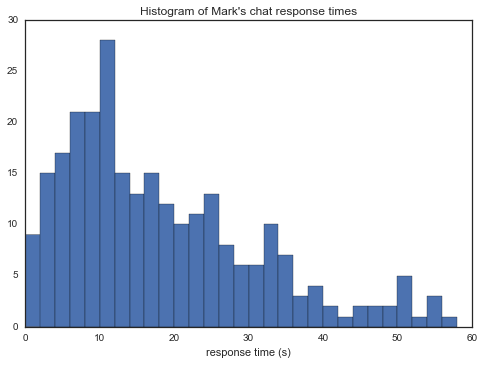

In [4]:
resp = np.array(data[data.columns[0]])
plt.hist(resp, bins=np.arange(0, 60, 2))
plt.xlabel("response time (s)")
plt.title("Histogram of Mark's chat response times");

In [5]:
print "mean ", np.mean(resp)
print "median ", np.median(resp)
print "min ", np.min(resp)
print "max ", np.max(resp)

mean  18.0641509434
median  14.0
min  0
max  59


<div class="alert alert-warning">
The distribution of response times is right-skewed, with a mean of around 18 seconds, and data ranging from 0 to 59 seconds.
</div>

# derive and compute the maximum likelihood for a Poisson distribution

<div class="alert alert-warning">
From Gelman, p. 43, if a data point $y$ follows a Poisson distribution with rate $\theta$, then the probability distribution of a single observation $y$ is: <br><br>

$$p(y|\theta) = \frac{\theta^y e^{-\theta}}{y!}$$ <br>

for y = 0, 1, 2, ... and for a vector $y = (y_1, \dots\, y_n)$ of independent and identically distributed observations. <br><br>

The likelihood is: <br><br>

$$
\begin{aligned}
L(\theta) &= p(y_1|\theta)\,p(y_2|\theta)\,\dots \,p(y_n|\theta) \\
&= \frac{\theta^{y_1} e^{-\theta}}{y_1!}\frac{\theta^{y_2} e^{-\theta}}{y_2!}\dots \frac{\theta^{y_n} e^{-\theta}}{y_n!} \\
&= \frac{\theta^{\sum_{i=1}^n y_i} e^{-n\theta}}{y_1!y_2!\dots y_n!} \\ \\
\end{aligned} 
$$

We take the logarithm and then maximize, by taking its derivative, setting that to zero, and solving for $\theta$: <br><br>

$$
\log L(\theta) = \sum_{i=1}^n y_i \log \theta - n \theta - \log (y_1!y_2!\dots y_n!) \\ 
$$
$$
\frac{d}{d\theta} \, \log L(\theta) = \sum_{i=1}^n y_i \frac{1}{\theta} - n = 0 \\
$$
$$
\sum_{i=1}^n y_i = n \theta \\
\theta = \frac {\sum_{i=1}^n y_i} {n} = \bar{y} \\ \\
$$

and this expression for the MLE is equal to the <strong>mean</strong> of the observations (which for our example is approximately 18, as calculated in the summary statistics above).

</div>

## Bayesian analysis and Metropolis Hastings

<div class="alert alert-info">
References cited: <br>
Gelman, Chapter 2 <br>
https://en.wikipedia.org/wiki/Jeffreys_prior <br>
Niemi, Bayesian Inference for Poisson Data (Youtube)
</div>

<div class="alert alert-warning">
Let $y_i$ be the number of seconds we observed it took Mark to respond to the $i$th message. We have assumed $y_i$ is distributed as Poisson with rate $\theta$ as noted above, and that the observations are i.i.d. We have shown that $E[y_i] = \mu$, where $\mu$ is the mean of the observations.<br><br>

Our objective is to derive the posterior distribution for $\theta$: $p(\theta|y) \propto p(y|\theta)p(\theta)$. <br><br>

First, with regard to the choice of prior, we actually do not have that much data to inform our choice of prior, and while we might guess that the parameter $\theta$ might lie between 0 and 60 based on the histogram, we really don't know this for sure and perhaps it could be even larger. If we want to pick a prior distribution that lets the data "speak for itself" and thus play a minimal role in the posterior distribution, we can choose a <strong>noninformative prior</strong>. One approach used to define noninformative prior distributions is to choose one that is invariant to transformations on the model parameter. For a Poisson likelihood, it can be shown (although we do not show it here) that the Jeffrey's prior is $p(\theta) = \frac{1}{\sqrt{\theta}}$. <br><br>

When using the Jeffrey's prior, it acts as if it is a Gamma(0.5, 0) distribution, such that we can use the updating formula (the Gamma distribution is the conjugate prior for the Poisson); the posterior will be distributed as $Gamma(0.5 + n\bar{y}, 0 + n)$ or $Gamma(0.5 + 59*18.064, 59)$ = $Gamma(1065, 59)$, and a point estimate for $\theta$ is the expected value of this distribution $1065/59 = 18.05$. This is consistent with our earlier answer. <br><br>

We understand that while we happened to choose a prior where we were able to ascertain the posterior distribution analytically and pretty easily, this will not generally be the case and it may be that we must resort to simulation. So we will proceed to apply Metropolis Hastings to sample from the posterior, in order to arrive at the posterior distribution. From the above formulas, the posterior distribution can be expressed as: <br>

$$p(\theta|y) \propto \frac{1}{\sqrt{\theta}} \prod_{i=1}^n \frac{\theta^{y_i} e^{-\theta}}{y_i!}$$ <br>

It is already obvious that if we are going to evaluate this expression, we will need to work in log space to avoid underflow and rounding error: <br>

$$
\begin{aligned}
\log p(\theta|y) &\propto - \frac{1}{2}\log\theta + \sum_{i=1}^n \log \left[\frac{\theta^{y_i} e^{-\theta}}{y_i!}\right]
\end{aligned}$$
</div>

In [6]:
def logpost(theta):
    # target distribution
    return -0.5 * np.log(theta) + np.sum(scipy.stats.poisson.logpmf(resp, theta))

In [7]:
# Metropolis Hastings algorithm
def mcmc(theta0, n, sig):
    count = 0
    result = np.zeros(n)
    r = np.random.random(n)
    
    for i in xrange(n):
        theta1 = np.random.normal(theta0, sig)  # propose new theta, draw from normal centered at current theta
        logp = logpost(theta1)-logpost(theta0)  # calculate test ratio in log space
        if np.log(r[i]) < logp:  # random draw from uniform (on log scale, to permit comparison)
            theta0 = theta1   # accept, otherwise reject 
            count += 1
        result[i] = theta0  # sample
    print "The acceptance rate of the chain is " + str(float(count)/N)
    return result

The acceptance rate of the chain is 0.30638


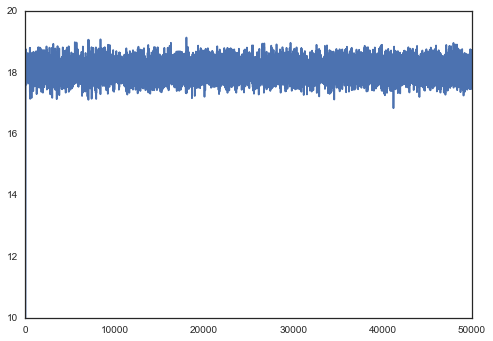

In [8]:
N = 50000  # number of simulations
theta0 = 10 # starting values
sigma = 1
trace = mcmc(theta0, N, sigma)

plt.plot(trace)
plt.show()

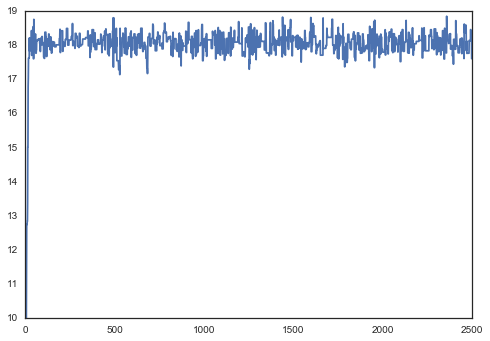

In [9]:
plt.plot(trace[0:2500])
plt.show()

<div class="alert alert-warning">
It looks like we can safely use 1000 as the burn-in period (perhaps even shorter)
</div>

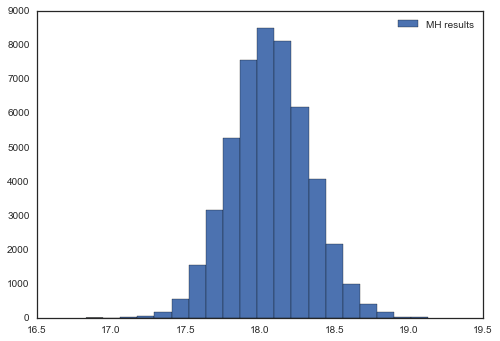

In [10]:
# plot histogram after the burn-in
burnin = 1000
trace_2 = trace[burnin:].copy()
plt.hist(trace_2, bins = 20, label="MH results")
plt.legend()
plt.show()

## Convergence Tests

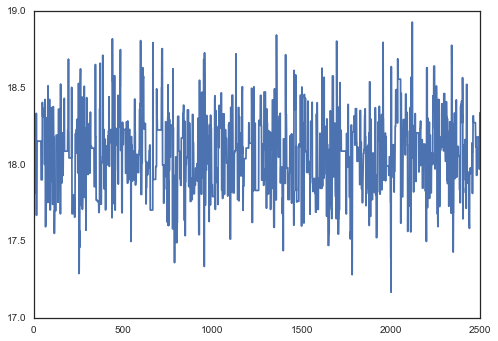

In [11]:
plt.plot(trace_2[:2500])
plt.show()

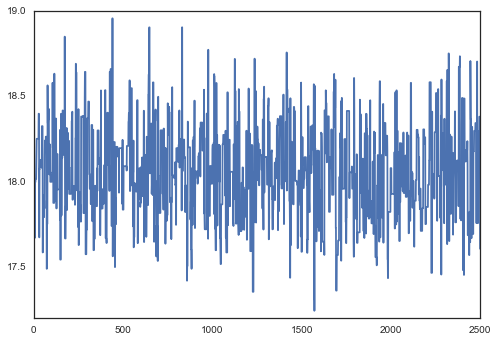

In [12]:
plt.plot(trace_2[-2500:])
plt.show()

<div class="alert alert-warning">
We compared a section from the beginning of the trace after the burn-in to a section near the end as a visual test for likely convergence. We also looked at the histograms for our parameter plotting using different sections of the trace, and did not notice any big warning signs. 
</div>

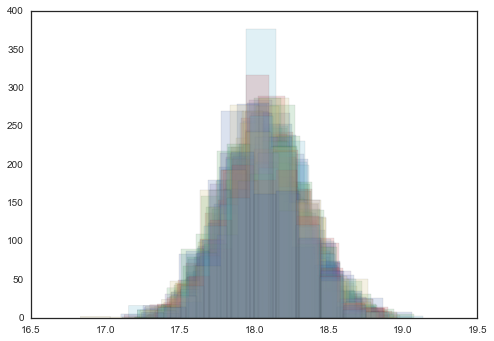

In [13]:
subsetSize = 1000
for i in range(49):
    plt.hist(trace_2[subsetSize*i:subsetSize*(i+1)], alpha=0.2)

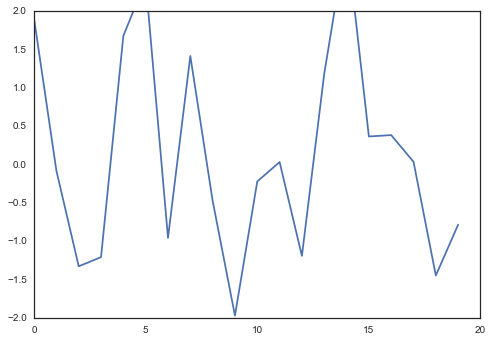

In [14]:
geweke_scores = Geweke(trace_2, 20, 1000)
plt.ylim((-2,2))
plt.plot(geweke_scores);

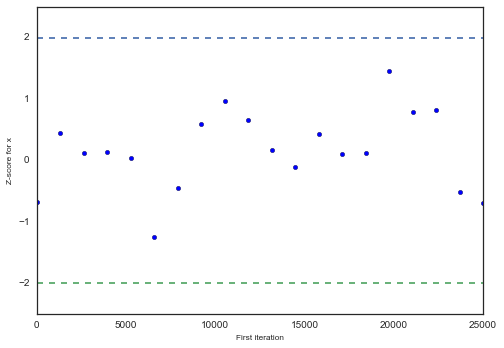

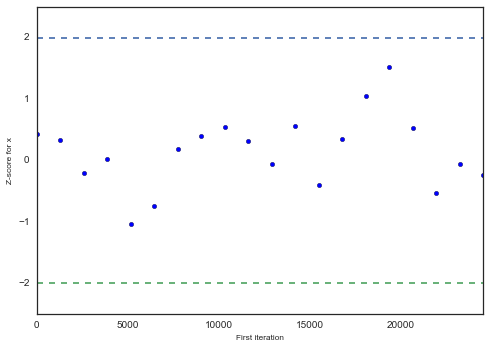

In [15]:
geweke_1 = pm.geweke(trace, first=0.1, last=0.5, intervals=20)
geweke_2 = pm.geweke(trace_2, first=0.1, last=0.5, intervals=20)

pm.Matplot.geweke_plot(geweke_1, 'x')
plt.show()

pm.Matplot.geweke_plot(geweke_2, 'x')
plt.show()

<div class="alert alert-warning">
We also ran the Geweke tests (using the given code) as well as the test from PyMC. The Geweke tests based on the "manual" algorithm seemed to indicate some signs of non-convergence. The PyMC version of the Geweke test did not have the same indications. Note we had to fiddle around with the parameters for the Geweke test in our algorithm, whereas PyMC does this for us automatically. 
</div>

In [16]:
# np.mean(trace_3), np.std(trace_3)
np.mean(trace_2), np.std(trace_2)

(18.067305985144078, 0.26145690547974282)

## PyMC

<div class="alert alert-warning">
We then set up our model in PyMC. We looked at the beginning and ends of the traces using our previous method as well as PyMC. Interestingly, we noted that the necessary burn-in period seemed potential shorter for the PyMC execution. Furthermore, parameters such as step size (sigma), and segment length for the Geweke test, seemed to be automatically selected by PyMC.
</div>

In [18]:
# setup the model

# Jeffery's (scale-invariant) prior (see early discussion)
@pm.stochastic(observed=False)
def theta(value=10):
    return -1.0 * np.sqrt(1.0/value)

# response times
resptime = pm.Poisson('resptime', mu=theta, value=resp, observed=True)

model = pm.Model([theta, resptime])
mcmc = pm.MCMC(model)
mcmc.sample(iter=50000, burn=0)  # we set burnin to 0 for now to inform the plots below

 [-----------------100%-----------------] 50000 of 50000 complete in 2.3 sec

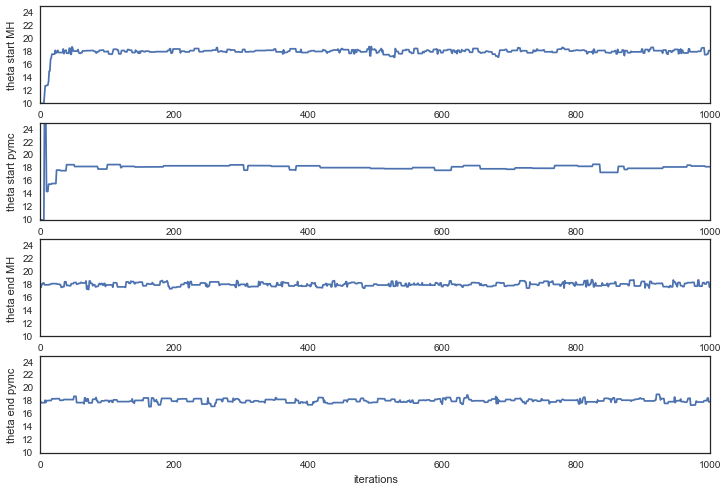

In [19]:
plt.figure(figsize=[12,8])

burnin = 1000

# trace plot for theta from our MH implementation
plt.subplot(4,1,1) 
plt.plot(trace[:burnin])
plt.ylim(10, 25)
plt.xlabel("iterations")
plt.ylabel("theta start MH")

# trace plot for theta from pymc
plt.subplot(4,1,2) 
plt.plot(theta.trace()[:burnin])
plt.ylim(10, 25)
plt.xlabel("iterations")
plt.ylabel("theta start pymc")

# trace plot for theta from our MH implementation
plt.subplot(4,1,3) 
plt.plot(trace[-burnin:])
plt.ylim(10, 25)
plt.xlabel("iterations")
plt.ylabel("theta end MH")

# trace plot for theta from pymc
plt.subplot(4,1,4) 
plt.plot(theta.trace()[-burnin:])
plt.ylim(10, 25)
plt.xlabel("iterations")
plt.ylabel("theta end pymc")

plt.show();

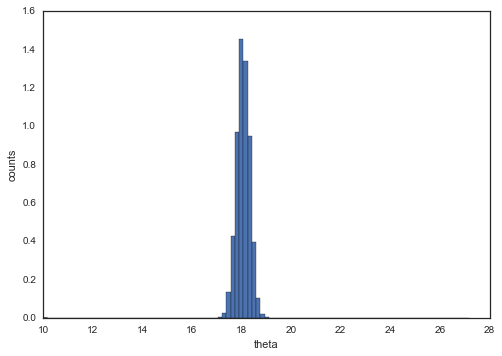

In [20]:
# histogram of theta
fig=plt.hist(theta.trace(), bins=100, normed=True)
plt.xlabel("theta")
plt.ylabel("counts");

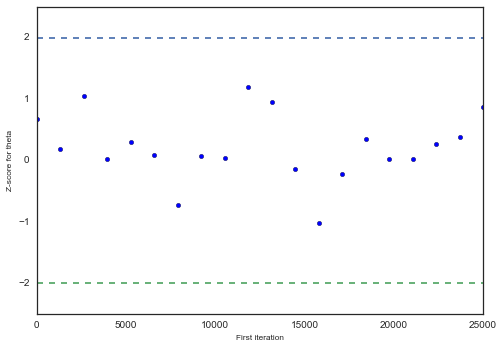

In [21]:
geweke_scores_4 = pm.geweke(theta.trace(), first=0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(geweke_scores_4, "theta")

<div class="alert alert-warning">
Occasionally, this plot appeared to indicate some points as being anomalous. This particular (random) run, does not provide any serious indication of non-convergence
</div>

Plotting theta


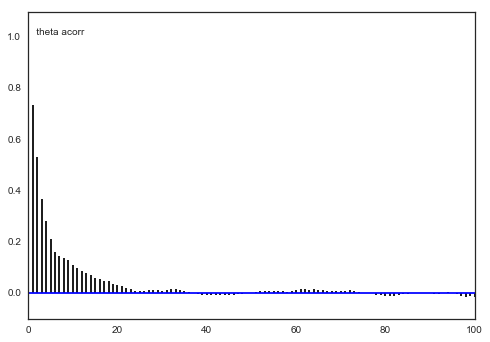

In [22]:
pm.Matplot.autocorrelation(theta.trace(), "theta")

<div class="alert alert-warning">
It appears we have significant autocorrelation here, which reduces our effective sample size.  We attempt a thinning technique, in an attempt to reduce the autocorrelation.
</div>

In [23]:
model_2 = pm.Model([theta, resptime])
mcmc2 = pm.MCMC(model_2)
mcmc.sample(iter=51000, burn=1000, thin=2)

 [-----------------100%-----------------] 51000 of 51000 complete in 2.1 sec

Plotting theta


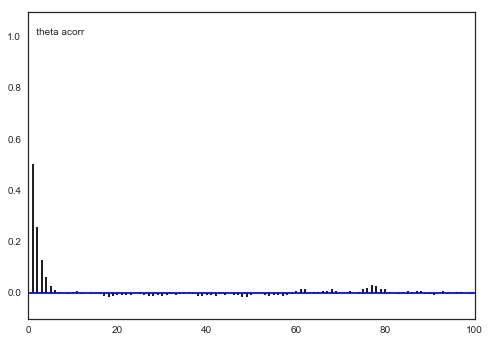

In [24]:
pm.Matplot.autocorrelation(theta.trace(), "theta")

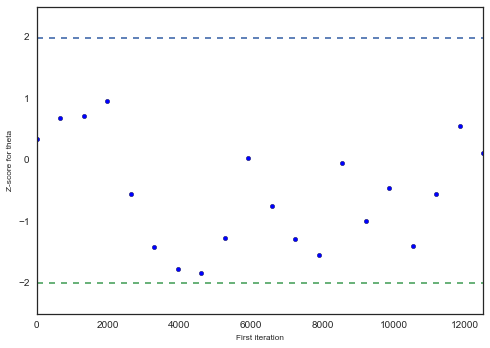

In [25]:
geweke_scores_5 = pm.geweke(theta.trace(), first =0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(geweke_scores_5, "theta")

<div class="alert alert-warning">
A bit better - less evidence of autocorrelation. We provide some summary output:
</div>

Plotting theta


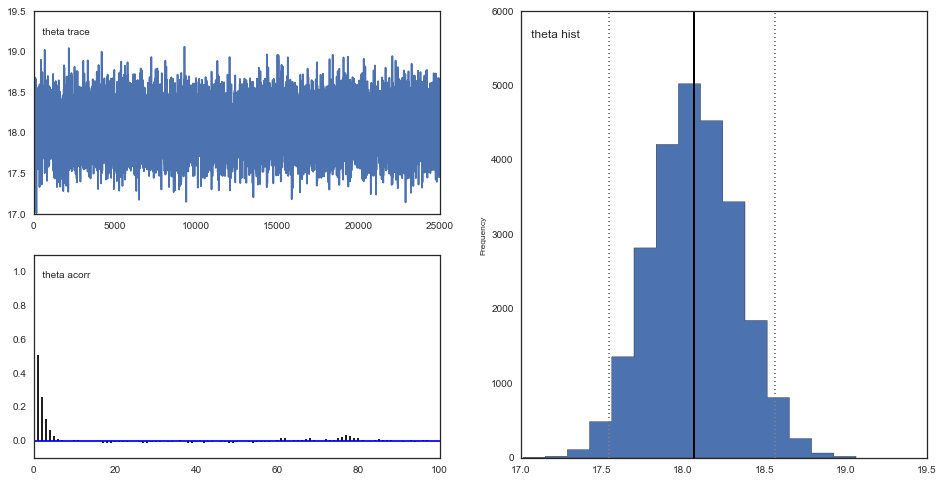

In [26]:
fig = plt.figure(figsize=(16,8))
pm.Matplot.plot(theta, new=False)

In [27]:
mcmc.summary()


theta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	18.066           0.281            0.002          [ 17.563  18.593]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	17.549           17.886          18.064         18.248        18.583
	


In [28]:
mcmc.stats()

{'theta': {'95% HPD interval': array([ 17.56289305,  18.5925197 ]),
  'mc error': 0.0022188942130772242,
  'mean': 18.065966360429247,
  'n': 75000,
  'quantiles': {2.5: 17.549176082369225,
   25: 17.886401787555709,
   50: 18.064475353077857,
   75: 18.247676846903452,
   97.5: 18.583074343304723},
  'standard deviation': 0.28083124416015248}}

<div class="alert alert-warning">
We note that PyMC gives us a lot of useful statistics, like the 95% HPD interval along with a point estimate.
</div>

## comparison of approaches

<div class="alert alert-warning">
The maximum likelihood solution and the Bayesian solution appear to be consistent, at least insofar as both point estimates for $\theta$ appear to be close. In both cases, $\theta$ is estimated to be around 18. However, we can generate a posterior predictive distribution as a further check, where we test the model by generating data from it and see how close it is to the data that we actually got. <br><br>

More specifically, we simulate a value for $\theta$ from our posterior distribution, and then use that value to simulate from our Poisson distribution (likelihood) given that simulated value of $\theta$. By repeating this procedure, we can effectively recreate a distribution for data that we would have generated from a model having the distribution of $\theta$ that we generated above. 
</div>

In [29]:
# posterior predictive: "simulate" a theta, simulate a response time, repeat
# for convenience, we use the samples we already have for the posterior
# and plug them into our likelihood to sample x

import random

samples = np.zeros(len(theta.trace()))

for i in xrange(len(theta.trace())):
    samples[i] = np.random.poisson(theta.trace()[i])

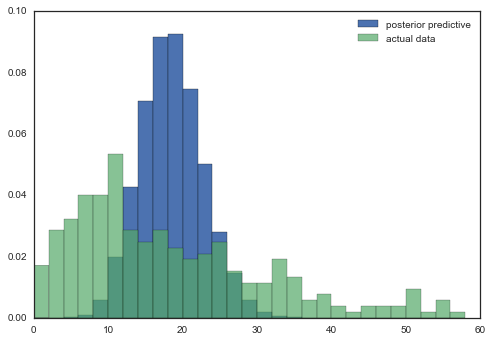

In [30]:
plt.hist(samples, bins=np.arange(0, 60, 2), label="posterior predictive", normed=True)
plt.hist(resp, alpha=0.7, bins=np.arange(0, 60, 2), label="actual data", normed=True)
plt.legend();

<div class="alert alert-warning">
The mean values were misleading. From the graph it appears that the Poisson model is actually not really a good choice to model the response times.
</div>

## alternative model

<div class="alert alert-warning">
We looked at the list of functions with a support of $[0, \infty]$ for ideas, and the illustrations of each. It became apparent that the Negative Binomial distribution seemed to be a decent choice for our problem:  https://en.wikipedia.org/wiki/Negative_binomial_distribution <br><br>

<blockquote>For occurrences of “contagious” discrete events, like tornado outbreaks, the Polya distributions can be used to give more accurate models than the Poisson distribution by allowing the mean and variance to be different, unlike the Poisson. “Contagious” events have positively correlated occurrences causing a larger variance than if the occurrences were independent, due to a positive covariance term. </blockquote>

This distribution probably makes more sense, as there is likely to be some correlation between successive messages. Also, there is greater flexibility by allowing both the mean and the variance parameters to vary.
</div>

In [31]:
# setup the model

# we select a flat prior this time, based partly on what the previous analysis has informed us
param1 = pm.Uniform("param", 0., 60.)
param2 = pm.Uniform("param2", 0., 10.)

# response times
resptime2 = pm.NegativeBinomial('resptime2', mu=param1, alpha=param2, value=resp, observed=True)

In [35]:
model_nb = pm.Model([param1, param2, resptime2])
mcmc = pm.MCMC(model_nb)
mcmc.sample(iter=52000, burn=2000, thin=4)  # we tweaked the burn-in and thinning parameters

 [-----------------100%-----------------] 52000 of 52000 complete in 5.9 sec

Plotting param


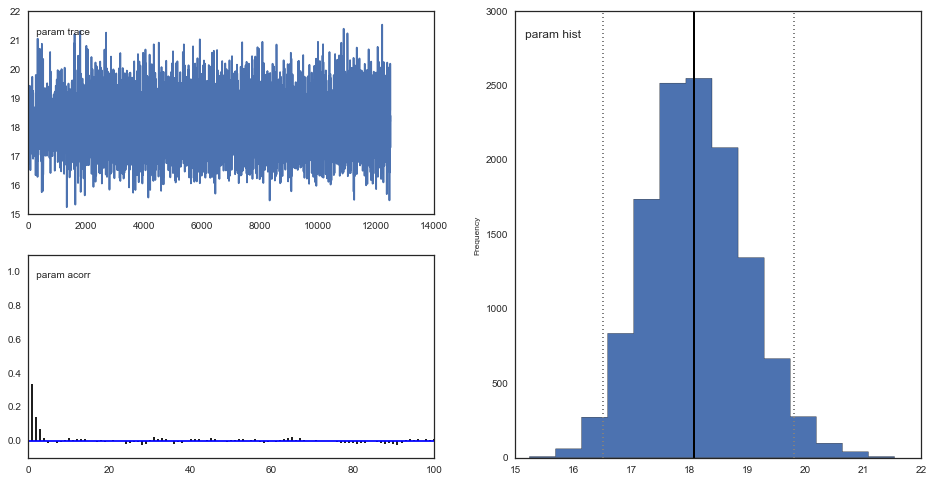

In [36]:
fig = plt.figure(figsize=(16,8))
pm.Matplot.plot(param1, new=False);

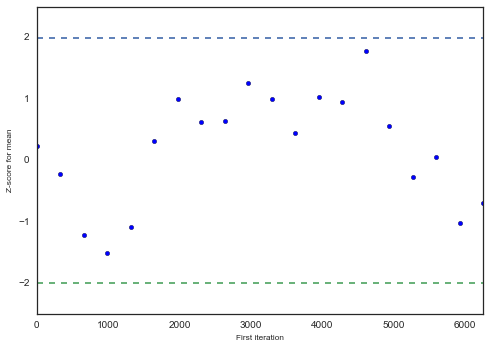

In [37]:
geweke_scores_6 = pm.geweke(param1.trace(), first=0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(geweke_scores_6, "mean")

In [38]:
mcmc.summary()


param:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	18.127           0.848            0.011          [ 16.513  19.808]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	16.555           17.54           18.091         18.688        19.865
	

param2:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	1.902            0.181            0.002            [ 1.557  2.263]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	1.566            1.777           1.895          2.019         2.277
	


In [39]:
mcmc.stats()

{'param': {'95% HPD interval': array([ 16.5130825 ,  19.80760521]),
  'mc error': 0.011366748238388283,
  'mean': 18.126781159604946,
  'n': 12500,
  'quantiles': {2.5: 16.555164958118848,
   25: 17.539579766090164,
   50: 18.090662862525619,
   75: 18.687766624877362,
   97.5: 19.865453590964762},
  'standard deviation': 0.84804756933948333},
 'param2': {'95% HPD interval': array([ 1.55749216,  2.26346976]),
  'mc error': 0.0019870006805018069,
  'mean': 1.9020452183476733,
  'n': 12500,
  'quantiles': {2.5: 1.5658183490531172,
   25: 1.7768230450642886,
   50: 1.894808574786502,
   75: 2.0189803438686407,
   97.5: 2.2766560442169768},
  'standard deviation': 0.18063323093659969}}

In [41]:
#posterior predictive
resp2sim = pm.NegativeBinomial('Neg Bin', mu=np.mean(param1.trace()), alpha=np.mean(param2.trace()))

In [42]:
posterior_predictive_model = pm.Model([resp2sim])
mcmc = pm.MCMC(posterior_predictive_model)
mcmc.sample(iter=51000, burn=1000, thin=10)

 [-----------------100%-----------------] 51000 of 51000 complete in 1.8 sec

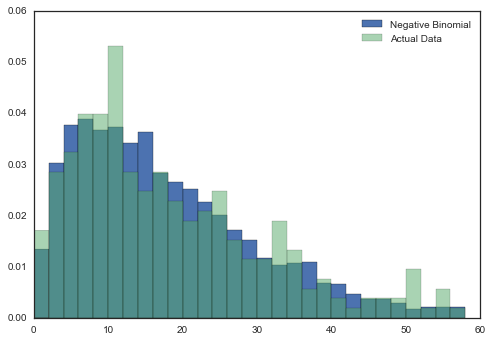

In [43]:
plt.hist(resp2sim.trace(), bins=np.arange(0, 60, 2), normed=True, label = "Negative Binomial")
plt.hist(resp, alpha = 0.5, bins=np.arange(0, 60, 2), normed=True, label = "Actual Data");
plt.legend();

<div class="alert alert-warning">
We took a slightly different approach this time, simulating response times based on the mean values of the parameters (keeping them fixed) and then normalizing the two histograms for comparison. As can be seen, this histogram does appear to capture the shape of the data better, suggesting the Negative Binomial distribution is a better choice. 
</div>

# Problem 3: Markov Chains

* Given the following transition matrix, examine if the corresponding Markov Chain is irreducible and aperiodic. Note: No formal proof necessary, but you should give a solid argumentation.

$$ P = \left( 
\begin{array}{ccccc}
0.0 & 0.4 & 0.6 & 0.0 & 0.0 \\
0.65 & 0.0 & 0.35 & 0.0 & 0.0 \\
0.32 & 0.68 & 0.0 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.12 & 0.88 \\
0.0 & 0.0 & 0.0 & 0.56 & 0.44 
\end{array}
\right ) $$



<div class="alert alert-danger">
The corresponding Markov Chain is NOT irreducible, but it is aperiodic.
</div>

<div class="alert alert-info">
We have made an example of a state diagram available online at the following link: <br>
(source: Bret Victor visualization tool) <br><br> 
http://setosa.io/markov/index.html#%7B%22tm%22%3A%5B%5B0%2C0.4%2C0.6%2C0%2C0%5D%2C%5B0.65%2C0%2C0.35%2C0%2C0%5D%2C%5B0.32%2C0.68%2C0%2C0%2C0%5D%2C%5B0%2C0%2C0%2C0.12%2C0.88%5D%2C%5B0%2C0%2C0%2C0.56%2C0.44%5D%5D%7D)
</div>

<div class="alert alert-warning">
We first constructed a state diagram (also "transition graph") based on this transition matrix, which is a directed graph that allows us to picture the state transitions. If we consider each of the rows and columns of the transition matrix to be associated with the following states {A, B, C, D, E}, we can determine the probability of transitioning from one state to the other. In the graph, we note that A, B, and C are connected and can reach each other (but not themselves directly), but D and E are in a separate graph (they can reach each other, and themselves directly). 

<br><br>
The corresponding Markov chain is <strong>irreducible</strong> if it is possible to get to any state from any state. From the state diagram it is clear that states {A, B, C} cannot communicate with states {D, E}. Therefore, the corresponding Markov chain is NOT irreducible. <br><br>

The corresponding Markov chain is <strong>aperiodic</strong> i.e. if a return to any given state can occur at irregular times. In other words, there should be no deterministic loops. With respect to states {A, B, C}, each of these states can return to itself after $k$ transitions for any $k>1$. <br><br>

For example, with respect to A: {(A -> B -> A), (A -> B -> C -> A), (A -> B -> C -> B -> A), (A -> B -> C -> B -> C -> A) ...} and so on, the total number of transitions required to return to A depending on the number of transitions between B and C. The same argument can be made with respect to each of B and C. <br><br>

Similarly, with respect to states {D, E}, each of these states can return to itself after $k$ transitions for $k>=1$. For example, with respect to D: {(D -> D), (D -> E -> D), (D -> E -> E -> D), ...} and so on, the total number of transitions required to return to D depending on the number of transitions between E to itself. The same argument can be made with respect to E. <br><br>

Therefore, since there is no fixed period greater than 1 for every state, the corresponding Markov chain IS aperiodic. <br><br>

Reference: https://en.wikipedia.org/wiki/Markov_chain

</div>

# Problem 4: The Evidence 

In lectures we mostly concentrate on the likelihood and the prior and regard the evidence as a mere normalization factor. However, the evidence can be quite useful. In this problem you will compare different models by computing the evidence for each model, aka the probability that randomly selected parameters from a given model class would generate the data $X$.

As our models we compare polynomials of degree 0 to 4. For example for degree 2 we have $y = a_0 + a_1 \cdot x + a_2 \cdot x^2 + \epsilon$ where $\epsilon \sim N(0, \sigma) $ and $\theta = [a_0, a_1, a_2, \sigma]$. Assume that for all polynomials $a_i \sim \text{Expo}(1)$ and $\sigma \sim \text{Inverse Gamma}(1,1)$.


Bayes' theorem states that:
$$
P(\theta|x)=\frac{P(x|\theta)P(\theta)}{P(x)}
$$
$P(\theta)$ is the prior, $P(x|\theta)$ is the likelihood, $P(x)$ is called the evidence, and $P(\theta|x)$ is the posterior.

Your tasks are:

* Write down the mathematical equation of the evidence in terms of the likelihood and the prior. You don't need to solve the integral analytically, just write down its formula.
* Now you have the evidence in the form of an integral. Solve it by using importance sampling. What is a good choice for your importance sampling distribution?
* Compare the evidence for polynomials of degree 0 to 4. Which polynomial wins?

<div class="alert alert-warning">
<strong>[External references used: Gelman, "Bayesian Data Analysis"]</strong> <br><br>
Before the data is considered, the distribution of the unknown by observable $x$ is given by Gelman (1.3):
$$
P(x) = \int P(X, \theta) \, d\theta = \int P(\theta)P(x|\theta) \, d\theta
$$

This can be referred to as the marginal distribution of $x$, which is sometimes also referred to as the prior predictive distribution of $x$. It is not conditional on data seen ("prior") and it is the distribution for an observable quantity ("predictive"). In any event, we will be using this to compare models, to see how likely a model is given randomly selected parameters.<br><br>

For polynomials of the above form, we are given the distributions of the coefficients and the standard deviation, so those quantities are known in the sense that we do not need to model their distributions or infer them from data. Therefore, for a model with given parameters, the variance in the likelihood comes strictly from the error term. Since the error term follows a normal distribution, the function $y$ given the parameters $\theta$ is also distributed as Normal. In the case of the fourth degree polynomial:

$$ f(y|\theta) \sim N(a_0 + a_1x + a_2x^2 + a_3x^3 +a_4x^4, \sigma) $$ <br>

To get the likelihood $P(x|\theta)$, we can plug in the mean and scaling factor from the above Normal distribution into the density function (PDF) for the normal, and multiply the probabilities over all N data points (assuming i.i.d. data): <br>

$$ 
\begin{aligned}
P(x|\theta) &= \prod_i^N \frac{1}{\sqrt{2\pi}\sigma} \exp\left[- \frac{(y_i - (a_0 + a_1x_i + a_2x_i^2 + a_3x_i^3 + a_4x_i^4))^2}{2\sigma^2}\right] \\
&= \frac{1}{(2\pi)^{N/2}\sigma^N} \exp\left[- \frac{\sum_i^N (y_i - (a_0 + a_1x_i + a_2x_i^2 + a_3x_i^3 + a_4x_i^4))^2}{2\sigma^2}\right]
\end{aligned}
$$
</div>

<div class="alert alert-warning">
In order to solving the integral for the evidence, we can use importance sampling. In importance sampling, we draw samples from an importance density $g(\theta)$:

$$
\begin{aligned}
\int P(\theta)P(x|\theta) \, d\theta &= \int P(\theta)P(x|\theta) \, \frac{g(\theta)}{g(\theta)} \, d\theta \\
&= \int \frac{P(\theta)P(x|\theta)}{g(\theta)} \, g(\theta) \, d\theta \\
& \approx \frac{1}{N} \sum \frac{P(\theta)P(x|\theta)}{g(\theta)}, \, \, \theta_i \sim g(\theta) \\
\end{aligned}
$$

<br><br>

We note that if we choose the prior distribution $P(\theta)$ itself as our importance sampling function $g(\theta)$, the term $P(\theta)$ cancels out and we are left with the task of performing brute force integration of the likelihood as given above: <br>

$$
P(x) = \int P(\theta)P(x|\theta) \, d\theta \approx \frac{1}{N} \sum P(x|\theta), \, \, \theta_i \sim g(\theta)
$$
<br>

Note that if we needed to compute the exact value of the integral, we would also need to compute a normalization factor; however, since our intention is to compare models, this will be a constant throughout and therefore we can ignore it for the sake of convenience. That said, to avoid underflow when computing the likelihood over n data points, it will be necessary to work in the log space. Thus we will evaluate the log likelihood for each model and compare those values across models: <br>

$$ 
\begin{aligned}
P(x|\theta) 
&= \frac{1}{(2\pi)^{N/2}\sigma^N} \exp\left[- \frac{\sum_i^N (y_i - (a_0 + a_1x_i + a_2x_i^2 + a_3x_i^3 + a_4x_i^4))^2}{2\sigma^2}\right] \\
\log P(x|\theta) 
&= - \frac{N}{2} \log(2\pi) - N \log\sigma - \left[\frac{\sum_i^N (y_i - (a_0 + a_1x_i + a_2x_i^2 + a_3x_i^3 + a_4x_i^4))^2}{2\sigma^2}\right] \\
\end{aligned}
$$
<br>
for the fourth degree polynomial, as an example.
</div>

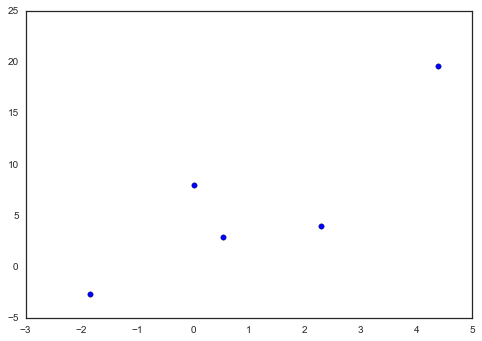

In [44]:
# Here is your data for the problem:
data = np.array([[ -1.85519254,  -2.7009541 ],
       [  4.38291824,  19.61735369],
       [  2.29495208,   3.96481822],
       [  0.02075668,   8.00646088],
       [  0.54097177,   2.8872262 ]])

x=data[:,0]
y=data[:,1]

# We take a look at the data points
plt.scatter(x, y, s=30);

In [45]:
def evaluate_log_lik(x, y, deg, N_total, plot=False):
    """ This function computes N_total values for the log likelihood function defined above, given
    data points (x, y) as n-length input vectors, and by sampling from the distributions for the
    parameters of theta. 'deg' specifies the degree of the polynomial up to degree 4."""
    
    assert (deg >= 0) & (deg <= 4)
    
    n = len(x)
    llvals = np.empty(N_total)
    
    # print sample plot with polynomials using sampled polynomial coefficients, atop data
    if plot:
        xx = np.linspace(-3, 5, 50)
        plt.figure()
        plt.xlim(-3, 5)
        plt.ylim(-5, 25)
        plt.scatter(x, y, s=30)  # original data
        plt.title("Model using polynomial of degree "+str(deg))
            
    for i in xrange(N_total):
    
        # numerator
        a = np.zeros(5)
        for d in range(5):
            if d<=deg:
                a[d] = np.random.exponential(1)  ## populate coefficients up to polynomial degree

        poly =  ((((a[4]*x + a[3])*x + a[2])* x + a[1])* x + a[0])
        diff_sq = (y - poly)**2  
        num = np.sum(diff_sq)

        # denominator
        sig = scipy.stats.invgamma.rvs(a=1.0)
        denom = 2.0 * sig**2

        llvals[i] = - (0.5 * n * np.log(2.0*np.pi)) - (n * np.log(sig)) - (num * 1.0/denom) 
        
        if plot:
            # plot curves
            plt.plot(xx, a[0] * (xx**0) + a[1] * xx + a[2] * (xx**2) + a[3]*(xx**3) + a[4]*(xx**4), alpha=0.05)
    
    return llvals

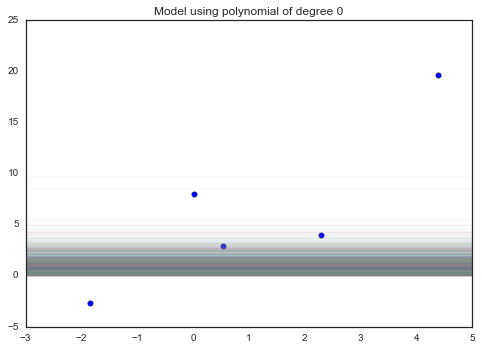

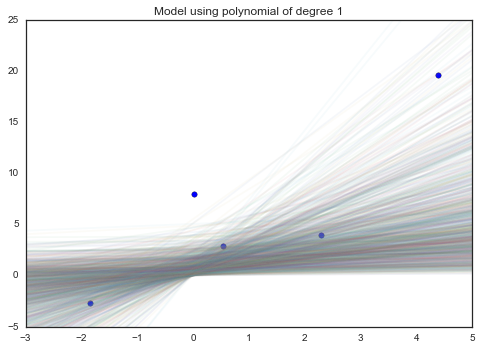

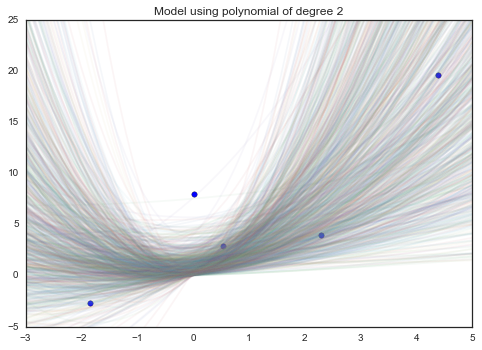

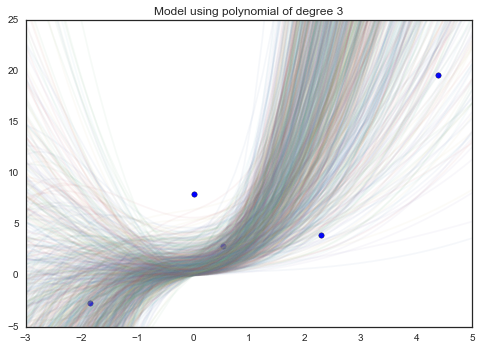

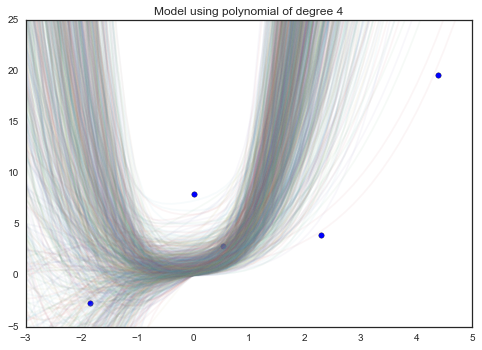

In [46]:
# run a test simulation to plot fitted curves for each polynomial based on sampled coefficients
for deg in range(5):    
    evaluate_log_lik(x, y, deg, 1000, plot=True)

<div class="alert alert-warning">
Based on these visualizations, it would appear that we are starting to get a sense that higher degrees of polynomials do not necessarily perform better. For example, the polynomial of degree 0 fails to fit the points with higher y-coordinates well; the pattern is not captured well at all. <br><br>

At the other extreme, the polynomial of degree 4 fails to fit the points with higher x-coordinates well. Although select curve instances might seem to decently fit the data, many of the other curve instances do not; thus, it is unlikely the model would generate that particular data given a random sampling of values for $\theta$. <br><br>

This appears to be an example of <strong>Occam's Razor</strong> at work: the evidence is the probability that if one randomly selected parameter values from a given model class, you would generate the data given. Models that are too simple will be very unlikely to generate that particular data set, whereas models that are too complex can generate many possible data sets, so again, they are unlikely to generate that particular data set at random. (Reference: http://papers.nips.cc/paper/1925-occams-razor.pdf). <br><br>

We can estimate the values of our log-likehood function, obtained by sampling using our selected prior via importance sampling, to see if we come to a conclusion consistent with what is suggested by the visualizations.
</div>

In [47]:
N_sims = 1000 # number of simulations performed
N_total = 1000  # number of samples per simulation

sims_array = np.empty((5, N_sims), dtype=float)  # store estimates of simulation, 5 polynomials

start = time.time()

for i in xrange(N_sims):
    for deg in range(5):
        sims_array[deg, i] = np.mean(evaluate_log_lik(x, y, deg, N_total))  # 1/N sumP(x|theta)
            
timer = time.time() - start
print '%0.2f seconds to complete %d simulations\n' % (timer, N_sims)

# output
for deg in range(5):
    print "degree %i polynomial" % deg
    print "MC estimate: %4f, error estimate: %4f \n" % (np.mean(sims_array[deg]), np.std(sims_array[deg]))

239.68 seconds to complete 1000 simulations

degree 0 polynomial
MC estimate: -434.622921, error estimate: 29.745194 

degree 1 polynomial
MC estimate: -297.601057, error estimate: 22.102672 

degree 2 polynomial
MC estimate: -567.673452, error estimate: 105.691956 

degree 3 polynomial
MC estimate: -15944.164832, error estimate: 2951.107480 

degree 4 polynomial
MC estimate: -357714.856320, error estimate: 57407.369833 



<div class="alert alert-warning">
We want the highest estimate for the evidence (this is proportional to the computed measure). Based on these results, it appears that the model based on <strong>a polynomial of degree 1 (a straight line) fits the given data best</strong>, with the distributions of the $\theta$ parameters constrained as given. This seems plausible given what was observed from the visualizations.

# Problem 5: Which YouTube Videos to Watch

Youtube videos have a like and an unlike flag. We can use these up and down votes on the videos to determine if a video is worth watching. However, it is not immediately obvious how to rank a video with just 3 up and 0 down rankings against a video with 300 up and 100 down votes. We will address this problem using a Bayesian approach.

Build two Bayesian models for the average upvote rate of a video. Both models should use the same likelihood, but different priors. Use one prior where people in general are rather undecided about videos, and one where people tend to be very opinionated. Compare the resulting posteriors for each video. How does the different choice of prior change your results? 

Given that there are so many videos on YouTube we want a really conservative way to decide if it is worth watching. Compute the 5th percentile for the posterior of each video and rank the videos according to this value. Is the 5th percentile a good indicator for the ranking? What are the benefits, what are potential drawbacks?

<div class="alert alert-warning">
<strong>[External references used: Gelman, "Bayesian Data Analysis"; Glickman, "Ch. 16, Basic Bayesian Methods" (web)]</strong> <br><br>

We want to know what the average upvote rate of a video is. If we were to model the real upvote rate as $\theta$, this is similar to earlier examples that we have come across, such as the "infected/not infected" example from class, or the "click/not click" example from the first lab. <br><br>

In a first step, <i>we formulate a probability model for the data</i>. The <strong>binomial</strong> distribution provides a natural model for data that arise from a sequence of draws from a large population where each trial gives rise to a "success" or "failure". In this case, we summarize the data by the total number of upvotes in $n$ total votes as $y$. Assuming the votes are i.i.d. random variables, we let the parameter $\theta$ represent the proportion of upvotes in the population. The binomial sampling model is: <br>

$$
p(y|\theta) = Bin(y| n, \theta) = {n \choose y}  \theta^y (1-\theta)^{(n-y)}
$$

which we can also consider our "likelihood function". <br><br>

The next step is to <strong>decide on a prior distribution</strong>, which quantifies the uncertainty in the values of
the unknown model parameters (which in our case is solely $\theta$) before the data are observed. We are given two pieces of information in the problem to inform our choice of prior distributions. In our view, the possibilities to consider depend highly on the interpretation of these statements. <br><br> 

For example, with respect to the statement "where people in general are rather undecided about videos", you could interpret this as suggesting that you have no information about the upvote rate that a given video should have, in which case it may be appropriate to use a <strong>uniform</strong> prior distribution, for example. This is an example of a "noninformative" prior distribution, which aims to be objective and suggests we have no prior knowledge about the parameters before observing the data. In implementation, this means that equal probability would be assigned to all possible values of the parameter (e.g. between 0 and 1 since $\theta$ is a proportion). In other words, we might expect that all values for $\theta$ between 0 and 1 are equally likely by using the uniform distribution as our prior. <br><br> 

On the other hand, we might also interpret the assertion that "people in general are rather undecided about videos" in a different way, namely that for a given video, a person would be just as likely to upvote or downvote the video; i.e. any voter is not going to feel strongly about the video either way, or may just pick one or the other option at random. Under this interpretation then, on average, we would not expect the rate $\theta$ to reach either extreme (0 or 1) often, but that rates will generally be centered at the mean of 0.5. In that case, a prior distribution where values near that mean are more likely might be more appropriate, such as a <strong>truncated normal</strong> distribution. <br><br>

A similar conundrum arises when consider the second statement "where people tend to be very opinionated". On the one hand, you could interpret this as suggesting that for any given video, people are going to feel very strongly one particular way OR the other, making it unlikely that the number of upvotes will be close to the number of downvotes. Under this intepretation, an appropriate prior distribution might have a mode at each of the extreme ends of the range; i.e. it is much likely that $\theta$ for a given video will be near 0 or near 1, with values in between being much less likely. We might think of this as a <strong>bimodal</strong> distribution of sorts. <br><br>

On the other hand, one might also intepret the assertion that "people tend to be very opinionated" as merely suggesting that the number of votes $n$ for a video is extremely high, as people tend to cast their votes in high volumes. However, in these types of situations a video might receive a lot of upvotes but it may also receive a lot of downvotes in equal quantity. In fact, one might be argue that any proportion is possible, since people being very opinionated does not necessarily mean "opinionated in only one direction". Under this interpretation, it might even be appropriate to use the uniform or some other distribution as a non-informative prior, since a video receiving a large number of votes does not give you any information on $\theta$ itself. <br><br>

For the purpose of this problem, we will proceed with the former pair of assumptions, by choosing the <strong>Uniform</strong> distribution as a non-informative prior as a first choice, and a distribution such as the <strong>Beta</strong> distribution with hyperparameters $\alpha = \beta = 0.5$ which has peaks tending to the extremes of the [0, 1] range, with lower possible values in between. (The use of a Beta distribution is also convenient choice as it is a conjugate prior for the binomial, although since we are using PyMC this may not have as significant practical impact for this exercise.)
</div>

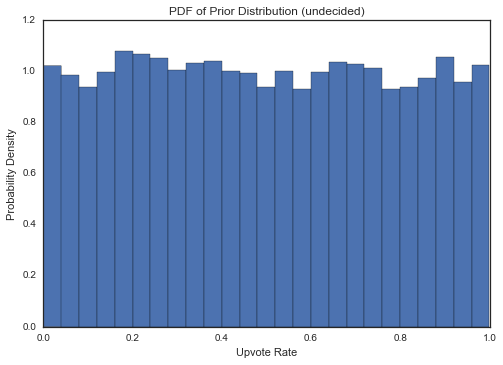

In [48]:
# Let's take a look at our choice of priors

N = 10000

# sample from the distributions N times
unifdist = np.random.uniform(0, 1, N)

plt.hist(unifdist, 25, normed=1)
plt.xlabel("Upvote Rate")
plt.ylabel("Probability Density")
plt.title("PDF of Prior Distribution (undecided)")
plt.xlim(0,1);

<div class="alert alert-warning">
Note that the uniform distribution can also be expressed as a Beta distribution with appropriately set parameters:
</div>

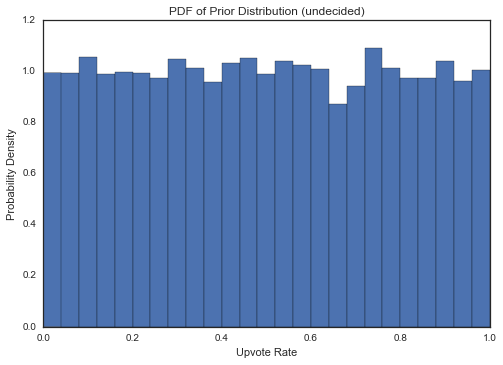

In [49]:
# set shape parameters
betaparams1 = [1, 1]

# sample from the distributions N times
betadist1 = np.random.beta(betaparams1[0], betaparams1[1], N)

plt.hist(betadist1, 25, normed=1)
plt.xlabel("Upvote Rate")
plt.ylabel("Probability Density")
plt.title("PDF of Prior Distribution (undecided)")
plt.xlim(0,1);

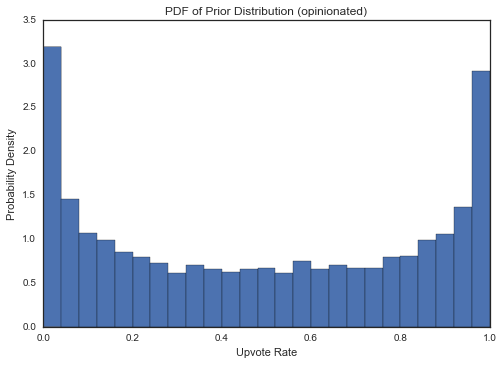

In [50]:
# set shape parameters for the Beta distribution (model 2)
betaparams2 = [0.5, 0.5]

# sample from the distributions N times
betadist2 = np.random.beta(betaparams2[0], betaparams2[1], N)

plt.hist(betadist2, 25, normed=1)
plt.xlabel("Upvote Rate")
plt.ylabel("Probability Density")
plt.title("PDF of Prior Distribution (opinionated)")
plt.xlim(0,1);

<div class="alert alert-warning">
Note that since the Beta distribution is a conjugate prior for the Binomial distribution (i.e. the posterior distribution will follow the same parameteric form as the prior distribution), we can readily derive the posterior in this case by simply adjusting the hyperparameters of the Beta distribution depending on the proportion of upvotes received for each video. <br><br>

Reference: https://en.wikipedia.org/wiki/Beta_distribution
</div>

In [51]:
# Here is the [upvote, downvote] data for 4 different videos:
video_votes = np.array([[3,0],[300,100],[2,2],[200,100]])

mean for video 1: 0.800000
s.d. for video 1: 0.163299
5th percentile for video 1: 0.472871

mean for video 2: 0.748756
s.d. for video 2: 0.021606
5th percentile for video 2: 0.712521

mean for video 3: 0.500000
s.d. for video 3: 0.188982
5th percentile for video 3: 0.189255

mean for video 4: 0.665563
s.d. for video 4: 0.027104
5th percentile for video 4: 0.620355



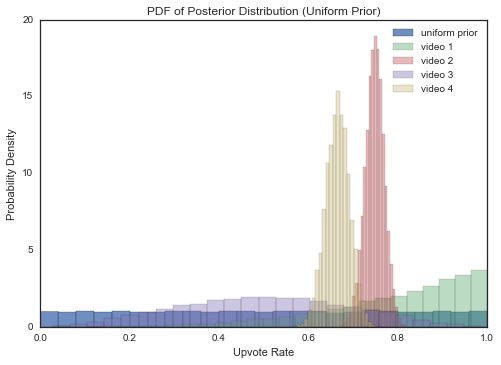

In [52]:
from scipy.stats import beta
plt.hist(betadist1, 25, normed=1, alpha=0.8, label="uniform prior")  # prior

for i, video in enumerate(video_votes):
    a, b = (1 + video[0]), (1 + video[1])  # alpha, beta
    posterior_dist_unifpr = np.random.beta(a, b, N)
    plt.hist(posterior_dist_unifpr, 25, normed=1, label="video "+str(i+1), alpha = 0.4)
    print "mean for video %i: %4f" % (i+1, a*1.0/(a + b))
    print "s.d. for video %i: %4f" % (i+1, np.sqrt((a * b * 1.0)/((a + b)**2 * (a + b + 1))))
    # could also estimate by subtracting 2 s.d.
    print "5th percentile for video %i: %4f\n" % (i+1, scipy.stats.beta.ppf(0.05, a, b)) 

plt.xlabel("Upvote Rate")
plt.ylabel("Probability Density")
plt.title("PDF of Posterior Distribution (Uniform Prior)")
plt.legend(loc="best")
plt.xlim(0,1);

mean for video 1: 0.875000
s.d. for video 1: 0.147902
5th percentile for video 1: 0.555933

mean for video 2: 0.749377
s.d. for video 2: 0.021615
5th percentile for video 2: 0.713123

mean for video 3: 0.500000
s.d. for video 3: 0.204124
5th percentile for video 3: 0.165280

mean for video 4: 0.666113
s.d. for video 4: 0.027138
5th percentile for video 4: 0.620845



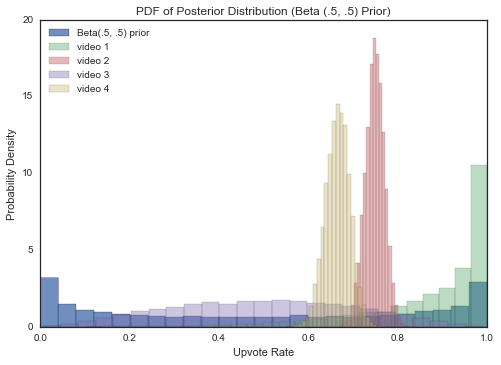

In [53]:
plt.hist(betadist2, 25, normed=1, alpha=0.8, label="Beta(.5, .5) prior")  # prior

for i, video in enumerate(video_votes):
    a, b = (0.5 + video[0]), (0.5 + video[1])  # alpha, beta
    posterior_dist_endspr = np.random.beta(a, b, N)
    plt.hist(posterior_dist_endspr, 25, normed=1, label="video "+str(i+1), alpha = 0.4)
    print "mean for video %i: %4f" % (i+1, a*1.0/(a + b))
    print "s.d. for video %i: %4f" % (i+1, np.sqrt((a * b * 1.0)/((a + b)**2 * (a + b + 1))))
    # could also estimate by subtracting 2 s.d.
    print "5th percentile for video %i: %4f\n" % (i+1, scipy.stats.beta.ppf(0.05, a, b))

plt.xlabel("Upvote Rate")
plt.ylabel("Probability Density")
plt.title("PDF of Posterior Distribution (Beta (.5, .5) Prior)")
plt.legend(loc="best")
plt.xlim(0,1);

<div class="alert alert-warning">
We notice that the posterior distributions for videos 2 and 4 look comparable for both choices of priors. This is not that surprising since both of those videos provide a lot of data points. Since there is a lot more information supplied for these videos, the posterior intervals are quite narrow, and there is not much reliance on the particular prior. Intuitively, there is enough data available that the data "speaks for itself". The expected values of the posterior distributions calculated above are consistent with these observations. <br><br>

In contrast, when there are only a few data points (e.g. videos 1 and 3), the resulting posterior intervals are relatively wider. This is also evidenced in a comparison of the computed standard deviations for the posterior distributions. <br><br>

Furthermore, with respect to the influence of the prior, we see that for video 3, the data suggests a rate of around 0.5 for both priors: for the "non-informative" uniform prior, the posterior is influenced slightly by what the data suggests (nudged toward a distribution peaking at 0.5), and the same can be said for the Beta prior given that the data seen is wholly inconsistent with the prior distribution. In other words, neither of the priors are particularly consistent with the data seen. <br><br>

However, where the data is consistent with the Beta prior, as for video 1, despite the low supply of information the model is more confident that the rate will indeed be closer to 1.0, and this is reflected in the taller bar in the last graph as well as the larger mean (relative to the uniform prior case).
</div>

<div class="alert alert-warning">
With respect to the ranking of videos according to the 5th percentile (also shown above), for both priors the videos would be ranked (2, 4, 1, 3), from best to worst. The 5th percentile appears to be a decent metric if we want to be conservative. On the one hand, the drawback of such a ranking is that it can fail to capture some potentially good videos: we notice that video 1 has a 100% upvote rate -- higher than all other videos -- yet that is not reflected in the rankings. The video has the potential to be superior if the trend continues in the future, and indeed we could be missing out. <br><br>

On the other hand, the 5th percentile metric does manage to capture the uncertainty that comes with the fact that there are so few data points supporting that high upvote rate (e.g. perhaps only the video poster and his/her friends voted for it). Therefore, the effective "penalty" that is reflected in using the 5th percentile as a performance metric can actually be a benefit, particularly if you want to be more certain that a video is good and only trust a ranking if a large number of people have rated the video highly.
</div>